In [4]:
import joblib
import mne
import os
import matplotlib.pyplot as plt
from collections import Counter
from add_subject_utils import depth, get_subj_data
import pandas as pd
import numpy as np

Mini raw file to check things quickly

In [ ]:
sfreq = 100  # Sampling frequency in Hz
n_channels = 3  # Number of EEG channels
n_samples = 100  # Number of time points

# Create some random data (3 channels, 1000 time points)
data = np.random.randn(n_channels, n_samples)

# Create channel names and types
ch_names = ["E101", "E102", "E103"]
ch_types = ["eeg"] * n_channels  # All channels are EEG

# Create MNE info structure
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)

# Create Raw object
raw = mne.io.RawArray(data, info)
get_subj_data(raw, "E101", "735", depth=False)

Subjects inspection

In [7]:
mne.set_log_level("error")
scalp = ["C3", "C4", "F3", "F4"]

In [4]:
# checking the channels
dir = r"I:\Shaked\clean_with_scalp"
files = sorted(os.listdir(dir))
files = [x for x in files if x.split(".")[0][-2:] != "-1"]
scalp_by_subject = {}
print(f"Number of subjects: {len(files)}")
for file in files:
    sub = file.split("_")[0][1:]
    raw = mne.io.read_raw(os.path.join(dir, file))
    if any(x in raw.ch_names for x in scalp):
        scalp_by_subject[sub] = [x for x in scalp if x in raw.ch_names]
        
print(f"Number of subjects with scalp: {len(scalp_by_subject)}")

Number of subjects: 34
Number of subjects with scalp: 34


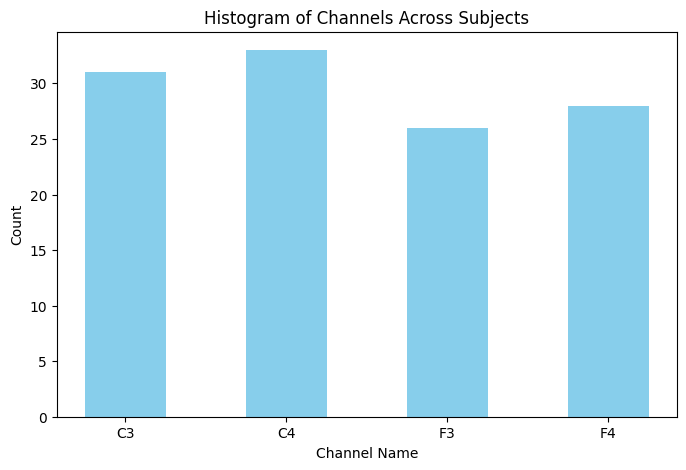

In [5]:
all_channels = [ch for channels in scalp_by_subject.values() for ch in channels]
channel_counts = Counter(all_channels)

plt.figure(figsize=(8, 5))
plt.bar(channel_counts.keys(), channel_counts.values(), color='skyblue', width=0.5)
plt.xticks()
plt.xlabel("Channel Name")
plt.ylabel("Count")
plt.title("Histogram of Channels Across Subjects")
plt.show()

In [6]:
channel_counts

Counter({'C4': 33, 'C3': 31, 'F4': 28, 'F3': 26})

### Features and depth vector extraction 
After making sure it's all good for one subject, better run all of them continuously from extract_features.py

In [1]:
# Define running parameters
model_name = "lgbm_full_f15_s25_b_V5.pkl"
use_all_channels = True
confidence = 0.8
num_channels_agreement = 2
dir = r"I:\Shaked\test1"

In [2]:
# run this only at the beginning of this test
info_path = rf"{dir}\info.txt"
with open(info_path, "w") as f:
    f.write(f"model_name: {model_name}\n")
    f.write(f"use_all_channels: {use_all_channels}\n")
    f.write(f"confidence: {confidence}\n")
    f.write(f"num_channels_agreement: {num_channels_agreement}\n")

In [5]:
# run depth model for creating labels
depth_model, features = joblib.load(rf"I:\Shaked\{model_name}").values()

C:\Users\Shaked\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.2.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [25]:
sub = "59"
clean_raw = mne.io.read_raw_fif(fr'I:\Shaked\clean_with_scalp\P{sub}_mtl_clean.fif')
nan_clean = clean_raw.get_data(reject_by_annotation='NaN')
nan_raw = mne.io.RawArray(nan_clean, clean_raw.info)

In [ ]:
# extract depth features - example for one channel (all channels in next cells)
chan = 'LA1'
curr_data = nan_raw.pick(chan)
curr_data.crop(60 * 60 * 1 + 60 * 20, 60 * 60 * 1 + 60 * 25)
subj_data = get_subj_data(curr_data, chan, sub, depth=True)
prob = depth_model.predict_proba(subj_data[features])[:, 1]
y_depth = (prob >= confidence).astype(int)

In [26]:
curr_channels = [chan for chan in nan_raw.ch_names if chan in depth]
if not use_all_channels:
    # get only one deepest channel from each brain region
    min_indexes = {}
    for item in curr_channels:
        prefix = item[:-1]
        index = int(item[-1])
        if prefix not in min_indexes or index < int(min_indexes[prefix][-1]):
            min_indexes[prefix] = item
    curr_channels = list(min_indexes.values())

In [ ]:
# extract depth features
total_y = None
for chan in curr_channels:
    curr_data = get_subj_data(nan_raw, chan, sub, depth=True)
    predictions = depth_model.predict_proba(curr_data[features])
    curr_y = (predictions[:, 1] >= confidence).astype(int)
    print(f"{chan}: {sum(curr_y)} spikes")
    if total_y is None:
        total_y = curr_y
    else:
        # summing answers from all the channels
        total_y += curr_y

# at least X channels should be above threshold
total_y[total_y < num_channels_agreement] = 0
total_y[total_y >= num_channels_agreement] = 1
print(f"Number of spikes: {sum(total_y)}")
print(f"Spikes ratio: {total_y.sum() / len(total_y)}")

LA1: 333 spikes
LA2: 204 spikes
LEC1: 499 spikes
LEC2: 1494 spikes
RA1: 582 spikes
RA2: 681 spikes
REC1: 1032 spikes
REC2: 1804 spikes
Number of spikes: 1373
Spikes ratio: 0.013549252965441017


In [7]:
# save depth answers
np.save(fr"{dir}\y_depth_{sub}.npy", total_y)

In [8]:
# load depth answers (if needed)
total_y = np.load(fr"{dir}\y_depth_{sub}.npy")

In [8]:
# extract scalp features
scalp_channels = [["C4", "F3"], ["C3", "F4"]]
for channel_couple in scalp_channels:
    if all(ch in nan_raw.ch_names for ch in channel_couple):
        scalp1 = get_subj_data(nan_raw, channel_couple[0], sub, depth=False)
        scalp2 = get_subj_data(nan_raw, channel_couple[1], sub, depth=False)
        # combine and rename columns
        subj_feat = pd.concat([scalp1, scalp2], axis=1, ignore_index=True) 
        subj_feat.columns = [f'{channel_couple[0]}_{col}' for col in scalp1.columns] + [f'{channel_couple[1]}_{col}' for col in scalp2.columns]
        subj_feat.to_pickle(rf'{dir}\scalp_features_{"_".join(channel_couple)}_{sub}.pkl')
    else:
        print(f"Missing: {[x for x in channel_couple if x not in nan_raw.ch_names]}")